In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.layers import Dense, Concatenate
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from google.colab import files
import h5py


In [ ]:
# Subir archivo
uploaded = files.upload()
archivo_h5 = list(uploaded.keys())[0]


Saving data0.h5 to data0.h5


In [ ]:
# Cargar tensor
with h5py.File(archivo_h5, 'r') as f:
    for key in f.keys():
        if isinstance(f[key], h5py.Dataset):
            tensor_original = f[key][:]
            break

# Transformar (1450, 20, 8) a (1450 * 20, 8)
tensor_transformado = tensor_original.reshape(-1, 8)

# Crear DataFrame
df = pd.DataFrame(tensor_transformado)

# Reordenar columnas
nuevo_orden = [0, 7, 4, 5, 6, 1, 2, 3]
df = df.iloc[:, nuevo_orden]

# Poner nombres a las columnas
nombres_columnas = ['Wavelength', 'Mode Area','TE(Ex) fraction', 'wg TE fraction', 'wg TM fraction', 'Neff', 'Keff', 'Loss (dB/cm)']
df.columns = nombres_columnas

df = df.sort_values(by=['Wavelength', 'Mode Area'])

# Reiniciar índices de las filas
df = df.reset_index(drop=True)

#print(df.head(10))
# Guardar como Excel
#nombre_excel = archivo_h5.replace('.h5', '.xlsx')
#df.to_excel(nombre_excel, index=False)

#Descargar
#files.download(nombre_excel)

data_x = df.iloc[:,0:5]
data_y = df.iloc[:,5:8]


In [ ]:
# Split de validacion y prueba
x_train, x_test, y_train, y_test = train_test_split(
     data_x,
     data_y,
     test_size=0.3,
     random_state=42,
     shuffle = True)

x_val, x_test, y_val, y_test = train_test_split(
     x_test,
     y_test,
     test_size=0.5,
     random_state=42,
     shuffle = True)

print(x_train.shape)
print(x_val.shape)
print(x_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)


(20300, 5)
(4350, 5)
(4350, 5)
(20300, 3)
(4350, 3)
(4350, 3)


In [ ]:
# Verificar que todo coincida
print("Verificación de correspondencia:")
print(f"X_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {x_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {x_test.shape}, y_test shape: {y_test.shape}")

Verificación de correspondencia:
X_train shape: (20300, 5), y_train shape: (20300, 3)
X_val shape: (4350, 5), y_val shape: (4350, 3)
X_test shape: (4350, 5), y_test shape: (4350, 3)


In [ ]:
# Para las entradas:
scaler_x = StandardScaler()
x_train_scaled = scaler_x.fit_transform(x_train)
x_val_scaled = scaler_x.transform(x_val)
x_test_scaled = scaler_x.transform(x_test)

# Para las salidas - NORMALIZAR CADA UNA POR SEPARADO:
scaler_y1 = StandardScaler()  # Para Neff
scaler_y2 = StandardScaler()  # Para Keff
scaler_y3 = StandardScaler()  # Para Loss

# Normalizar cada columna individualmente
y1_train_scaled = scaler_y1.fit_transform(y_train.iloc[:, 0:1])  # Neff
y2_train_scaled = scaler_y2.fit_transform(y_train.iloc[:, 1:2])  # Keff
y3_train_scaled = scaler_y3.fit_transform(y_train.iloc[:, 2:3])  # Loss

# Aplicar misma transformación a validation y test
y1_val_scaled = scaler_y1.transform(y_val.iloc[:, 0:1])
y2_val_scaled = scaler_y2.transform(y_val.iloc[:, 1:2])
y3_val_scaled = scaler_y3.transform(y_val.iloc[:, 2:3])

y1_test_scaled = scaler_y1.transform(y_test.iloc[:, 0:1])
y2_test_scaled = scaler_y2.transform(y_test.iloc[:, 1:2])
y3_test_scaled = scaler_y3.transform(y_test.iloc[:, 2:3])

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K
import gc

def limpiar_completamente():
    """Limpia TODO incluyendo variables de modelo"""

    print(" Limpiando COMPLETAMENTE...")

    # Eliminar todas las variables relacionadas con modelos
    variables_a_eliminar = ['model', 'modelo', 'nn_model', 'red_neuronal']

    for var_name in variables_a_eliminar:
        try:
            del globals()[var_name]
            print(f"Variable '{var_name}' eliminada")
        except KeyError:
            pass

    # Limpiar sesión de Keras
    K.clear_session()
    print("Sesión de Keras limpiada")

    # Liberar memoria
    gc.collect()
    print("Memoria liberada")

    print("Limpieza COMPLETA - Kernel listo")

# USAR:
limpiar_completamente()

In [ ]:
input_shape = (x_train_scaled.shape[1],)

inputs = layers.Input(shape=input_shape, name='Waveline_inputs')


dense_1 = layers.Dense(256, activation='relu', name='Dense_1')(inputs)
dense_2 = layers.Dense(128, activation='relu', name='Dense_2')(dense_1)
dense_3 = layers.Dense(64, activation='relu', name='Dense_3')(dense_2)

# Ramas especializadas
# Rama para Keff
dense_4 = layers.Dense(32, activation='relu', name='Dense_4')(dense_3)

# Rama para Loss
dense_5 = layers.Dense(64, activation='relu', name='Dense_5')(dense_2)
dense_6 = layers.Dense(32, activation='relu', name='Dense_6')(dense_5)
dense_7 = layers.Dense(16, activation='relu', name='Dense_7')(dense_6)

# Salidas
output_1 = layers.Dense(1, activation='linear', name='Output_1')(dense_3)  # Neff
output_2 = layers.Dense(1, activation='linear', name='Output_2')(dense_4)  # Keff
output_3 = layers.Dense(1, activation='linear', name='Output_3')(dense_7)  # Loss

model = Model(inputs=inputs, outputs=[output_1, output_2, output_3])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Waveline_inputs     │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dense_1 (Dense)     │ (None, 256)       │      1,536 │ Waveline_inputs[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dense_2 (Dense)     │ (None, 128)       │     32,896 │ Dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dense_5 (Dense)     │ (None, 64)        │      8,256 │ Dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dense_3 (Dense)     │ (None, 64)        │      8,256 │ Dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dense_6 (Dense)     │ (None, 32)        │      2,080 │ Dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dense_4 (Dense)     │ (None, 32)        │      2,080 │ Dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dense_7 (Dense)     │ (None, 16)        │        528 │ Dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Output_1 (Dense)    │ (None, 1)         │         65 │ Dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Output_2 (Dense)    │ (None, 1)         │         33 │ Dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Output_3 (Dense)    │ (None, 1)         │         17 │ Dense_7[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 55,747 (217.76 KB)

 Trainable params: 55,747 (217.76 KB)

 Non-trainable params: 0 (0.00 B)

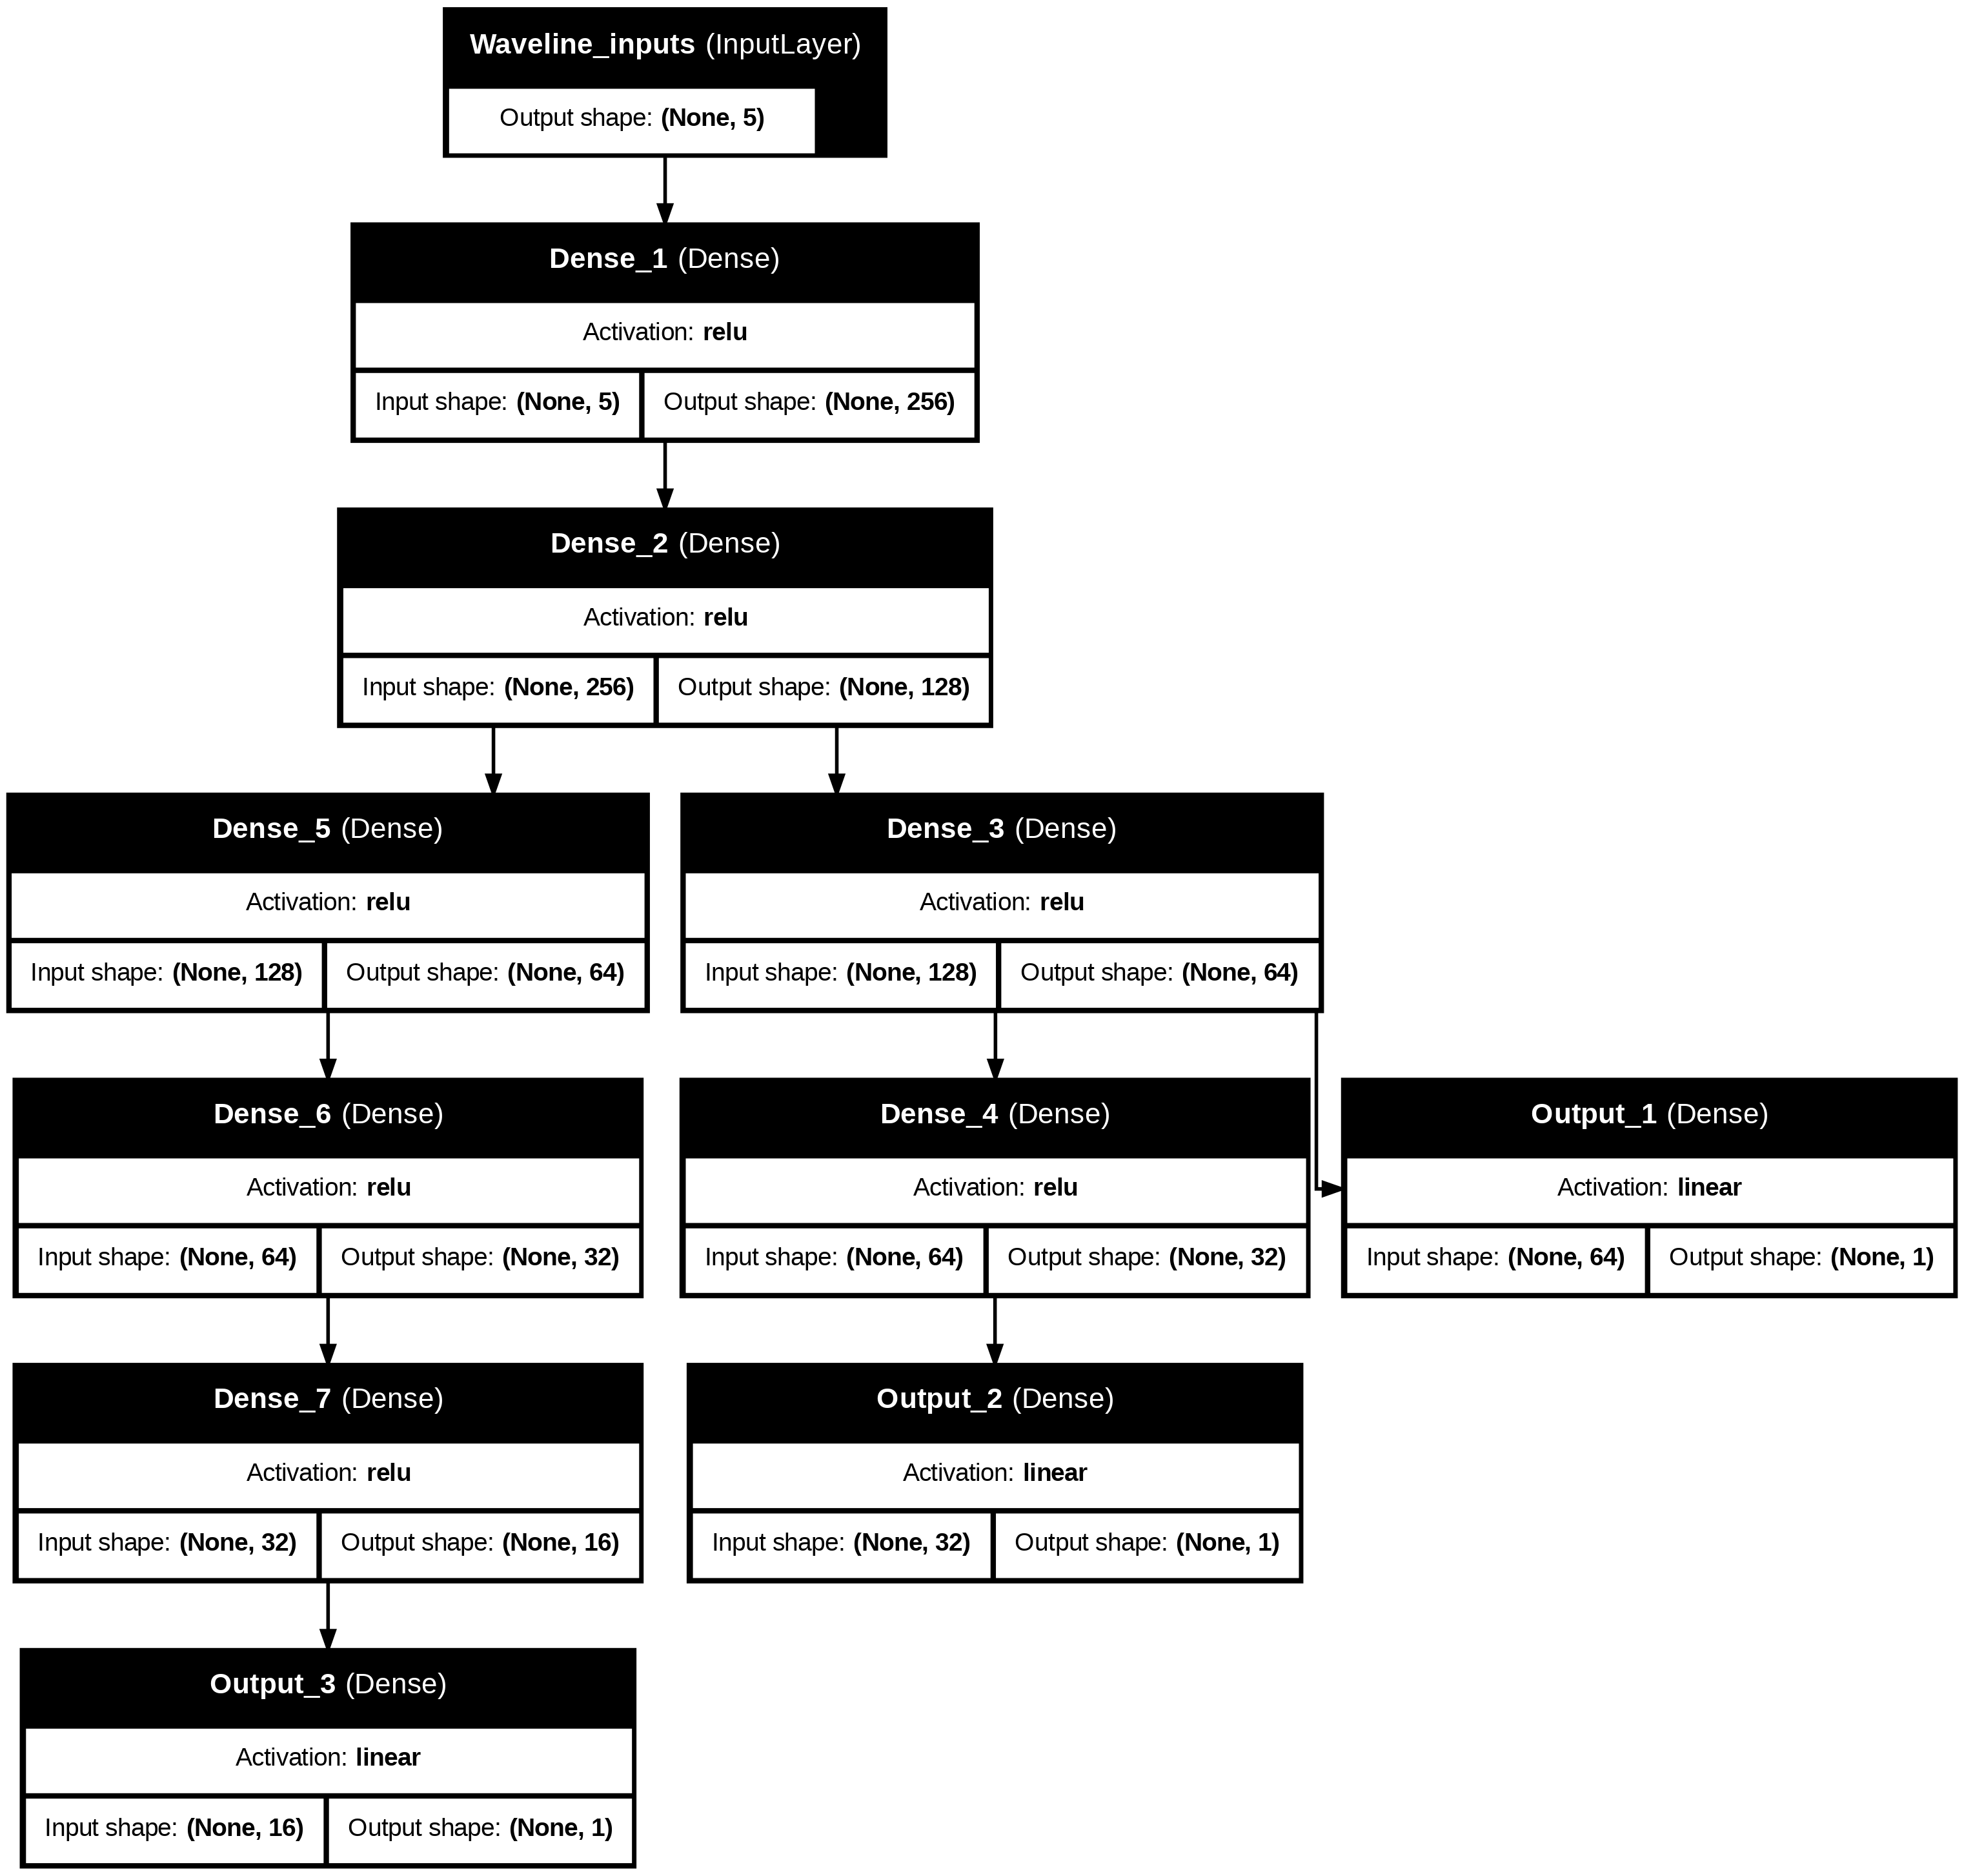

In [ ]:
#Generador de diagrama visual
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Concatenate
from tensorflow.keras.utils import plot_model
plot_model(
    model,
    to_file='model_architecture.png',
    show_shapes=True,
    show_layer_names=True,
    show_layer_activations=True,
    rankdir='TB'
)

In [ ]:
# Valores iniciales recomendados:
loss_weights = {
    'Output_1': 1.0,      # Neff
    'Output_2': 15.0,   # Keff
    'Output_3': 0.001     # Loss
}

model.compile(optimizer='adam',
              loss={'Output_1': 'mse', 'Output_2': 'mse', 'Output_3': 'mse'},
              loss_weights=loss_weights,
              metrics={'Output_1': 'mae', 'Output_2': 'mae', 'Output_3': 'mae'})

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Definir los callbacks
checkpoint_callback = ModelCheckpoint(
    filepath='mejor_modelo.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=1e-7,
    verbose=1
)

# Entrenar el modelo
history = model.fit(
    x_train_scaled,
    {'Output_1': y1_train_scaled.flatten(),  # Neff
     'Output_2': y2_train_scaled.flatten(),  # Keff
     'Output_3': y3_train_scaled.flatten()}, # Loss
    validation_data=(
        x_val_scaled,
        {'Output_1': y1_val_scaled.flatten(),
         'Output_2': y2_val_scaled.flatten(),
         'Output_3': y3_val_scaled.flatten()}
    ),
    epochs=500,
    batch_size=32,
    callbacks=[checkpoint_callback, early_stopping, reduce_lr],
    verbose=1
)

In [ ]:
import matplotlib.pyplot as plt

# EVALUACIÓN DEL MODELO
print("EVALUACIÓN DEL MODELO")
print("="*50)
score = model.evaluate(x_test_scaled,
                       {'Output_1': y1_test_scaled.flatten(),
                        'Output_2': y2_test_scaled.flatten(),
                        'Output_3': y3_test_scaled.flatten()},
                       verbose=1)
print('Test loss:', score[0])
print('Test metrics:', score[1:])

# Predicciónes
print("\nREALIZANDO PREDICCIONES...")
print("="*50)
y_pred1, y_pred2, y_pred3 = model.predict(x_test_scaled, verbose=1)





In [ ]:

# DESNORMALIZAR PREDICCIONES Y VALORES REALES
y1_pred_original = scaler_y1.inverse_transform(y_pred1)
y2_pred_original = scaler_y2.inverse_transform(y_pred2)
y3_pred_original = scaler_y3.inverse_transform(y_pred3)

y1_test_original = scaler_y1.inverse_transform(y1_test_scaled.reshape(-1, 1))
y2_test_original = scaler_y2.inverse_transform(y2_test_scaled.reshape(-1, 1))
y3_test_original = scaler_y3.inverse_transform(y3_test_scaled.reshape(-1, 1))

x_test_original = scaler_x.inverse_transform(x_test_scaled)

# CREAR DATAFRAME CON RESULTADOS
resultados_df = pd.DataFrame()

# Añadir entradas originales
for i, col_name in enumerate(data_x.columns):
    resultados_df[col_name] = x_test_original[:, i]

# Añadir salidas reales
resultados_df['Neff_real'] = y1_test_original.flatten()
resultados_df['Keff_real'] = y2_test_original.flatten()
resultados_df['Loss_real'] = y3_test_original.flatten()

# Añadir predicciones
resultados_df['Neff_pred'] = y1_pred_original.flatten()
resultados_df['Keff_pred'] = y2_pred_original.flatten()
resultados_df['Loss_pred'] = y3_pred_original.flatten()

# Calcular errores
resultados_df['Neff_error'] = resultados_df['Neff_real'] - resultados_df['Neff_pred']
resultados_df['Keff_error'] = resultados_df['Keff_real'] - resultados_df['Keff_pred']
resultados_df['Loss_error'] = resultados_df['Loss_real'] - resultados_df['Loss_pred']

# 5. IMPRIMIR DATASET COMPLETO ORGANIZADO
#print("\nDATASET COMPLETO ORGANIZADO")
#print("="*50)
#df_sorted = df.sort_values(by=[df.columns[0], df.columns[1]])  # Ordenar por col0 y col1
#print(df_sorted)

In [ ]:
rangos = {
    'Neff': data_y.iloc[:, 0].max() - data_y.iloc[:, 0].min(),
    'Keff': data_y.iloc[:, 1].max() - data_y.iloc[:, 1].min(),
    'Loss': data_y.iloc[:, 2].max() - data_y.iloc[:, 2].min()
}

predictions = [y1_pred_original, y2_pred_original, y3_pred_original]
reales = [y1_test_original, y2_test_original, y3_test_original]
nombres = ['Neff', 'Keff', 'Loss']

print("\n" + "="*70)
print("EVALUACIÓN DE MÉTRICAS - RANGOS AUTOMÁTICOS")
print("="*70)
print("Rangos calculados automáticamente:")
print(f"  Neff: {rangos['Neff']:.6f}")
print(f"  Keff: {rangos['Keff']:.6f}")
print(f"  Loss: {rangos['Loss']:.6f}")
print()

for i, (nombre, y_pred, y_real) in enumerate(zip(nombres, predictions, reales)):
    y_pred_flat = y_pred.flatten()
    y_real_flat = y_real.flatten()

    mae = mean_absolute_error(y_real_flat, y_pred_flat)
    r2 = r2_score(y_real_flat, y_pred_flat)
    error_relativo = (mae / rangos[nombre]) * 100

    print(f"\n {nombre}:")
    print(f"MAE: {mae:.6f}")
    print(f"R²: {r2:.4f}")
    print(f"Error relativo: {error_relativo:.2f}%")
    print(f"Rango real: {rangos[nombre]:.6f}")

    if error_relativo < 2:
        print(f"Excelente precisión")
    elif error_relativo < 5:
        print(f"Buena precisión")
    elif error_relativo < 10:
        print(f"Precisión aceptable")
    elif error_relativo < 20:
        print(f"Precisión regular")
    else:
        print(f"Precisión insuficiente")

In [ ]:
# Verificar que el modelo no memoriza (overfitting)
train_predictions = model.predict(x_train_scaled[:1000], verbose=0)  # Solo 1000 muestras
train_score = model.evaluate(x_train_scaled[:1000],
                            {'Output_1': y1_train_scaled[:1000].flatten(),
                             'Output_2': y2_train_scaled[:1000].flatten(),
                             'Output_3': y3_train_scaled[:1000].flatten()},
                            verbose=0)

print(f"\nCOMPARACIÓN ENTRE TRAIN Y TEST:")
print(f"Train loss: {train_score[0]:.4f}")
print(f"Test loss:  {score[0]:.4f}")  # Del evaluate anterior

# Si train_loss << test_loss → Overfitting
# Si son similares → Buen balance


COMPARACIÓN ENTRE TRAIN Y TEST:
Train loss: 0.0842
Test loss:  0.0499


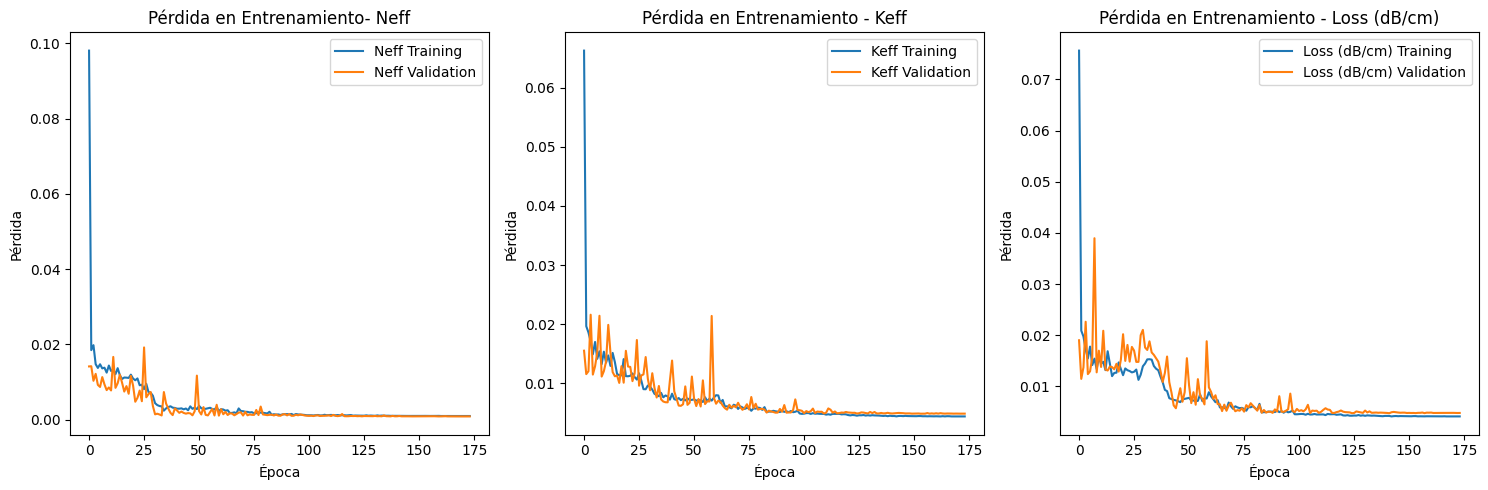

In [ ]:
# GRÁFICAS DE PÉRDIDA DEL ENTRENAMIENTO
plt.figure(figsize=(15, 5))

# Pérdida para Neff
plt.subplot(1, 3, 1)
plt.plot(history.history['Output_1_loss'], label='Neff Training')
plt.plot(history.history['val_Output_1_loss'], label='Neff Validation')
plt.title('Pérdida en Entrenamiento- Neff')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()

# Pérdida para Keff
plt.subplot(1, 3, 2)
plt.plot(history.history['Output_2_loss'], label='Keff Training')
plt.plot(history.history['val_Output_2_loss'], label='Keff Validation')
plt.title('Pérdida en Entrenamiento - Keff')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()

# Pérdida para Loss (dB/cm)
plt.subplot(1, 3, 3)
plt.plot(history.history['Output_3_loss'], label='Loss (dB/cm) Training')
plt.plot(history.history['val_Output_3_loss'], label='Loss (dB/cm) Validation')
plt.title('Pérdida en Entrenamiento - Loss (dB/cm)')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# GRÁFICAS DE COMPARACIÓN POR LONGITUD DE ONDA
resultados_ordenados = resultados_df.sort_values(by=[resultados_df.columns[0], resultados_df.columns[1]])

# Obtener longitudes de onda únicas
longitudes_onda = resultados_ordenados['Wavelength'].unique()

print(f"\nNúmero de longitudes de onda únicas en test: {len(longitudes_onda)}")

print("\n" + "="*50)
print("GRÁFICAS CON EJE X PROPORCIONAL")
print("="*50)

# Lista de variables a graficar
variables = ['Neff', 'Keff', 'Loss']

# Lista para guardar nombres de archivos
archivos_guardados = []

for variable in variables:
    print(f"\n" + "="*50)
    print(f"GRÁFICAS DE {variable.upper()}")
    print("="*50)

    for i, wavelength in enumerate(longitudes_onda):
        if i >= 20:
            break

        # Obtener datos para esta longitud de onda
        datos_wavelength = resultados_ordenados[resultados_ordenados['Wavelength'] == wavelength]

        if len(datos_wavelength) > 7:
            datos_wavelength = datos_wavelength.iloc[7:]

        # Crear posiciones X proporcionales
        mode_areas = datos_wavelength['Mode Area'].values
        x_positions = np.arange(len(mode_areas))

        plt.figure(figsize=(14, 6))

        # Graficar datos reales (ROJO) y predichos (AZUL)
        plt.plot(x_positions, datos_wavelength[f'{variable}_real'],
                 color='red', marker='o', linestyle='-',
                 label='Real', markersize=4, linewidth=1.5, alpha=0.8)
        plt.plot(x_positions, datos_wavelength[f'{variable}_pred'],
                 color='blue', marker='o', linestyle='--',
                 label='Predicho', markersize=4, linewidth=1.5, alpha=0.8)

        # Configurar etiquetas del eje X
        if len(x_positions) > 15:
            step = max(1, len(x_positions) // 10)
            selected_indices = x_positions[::step]
            selected_labels = [f'{mode_areas[i]:.1f}' for i in selected_indices]
            plt.xticks(selected_indices, selected_labels, rotation=45, fontsize=9)
        else:
            plt.xticks(x_positions, [f'{ma:.1f}' for ma in mode_areas], rotation=45, fontsize=9)

        # Títulos y etiquetas
        if variable == 'Loss':
            ylabel = 'Loss (dB/cm)'
        elif variable == 'Keff':
            ylabel = 'Keff'
        else:
            ylabel = variable

        plt.title(f'{variable} - Longitud de Onda: {wavelength*100:.0f} nm',
                  fontsize=14, fontweight='bold')
        plt.xlabel('Mode Area (μm²)', fontsize=12)
        plt.ylabel(ylabel, fontsize=12)
        plt.legend(fontsize=10)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()

        # Guardar la gráfica
        nombre_archivo = f'grafica_{variable}_{wavelength*100:.0f}nm.png'
        plt.savefig(nombre_archivo, dpi=300, bbox_inches='tight')
        archivos_guardados.append(nombre_archivo)

        plt.show()

# Crear archivo ZIP con todas las gráficas
print("\n" + "="*50)
print("CREANDO ARCHIVO ZIP CON LAS GRÁFICAS")
print("="*50)

import zipfile
import os

# Crear el archivo ZIP
with zipfile.ZipFile('todas_las_graficas.zip', 'w') as zipf:
    for archivo in archivos_guardados:
        if os.path.exists(archivo):
            zipf.write(archivo)
            print(f"Añadido: {archivo}")

print(f"\n Se guardaron {len(archivos_guardados)} gráficas en el ZIP")

# Descargar el archivo ZIP
print("\n DESCARGANDO ARCHIVO ZIP CON TODAS LAS GRÁFICAS...")
files.download('todas_las_graficas.zip')

# Opcional: También descargar gráficas individuales
print("\n DESCARGANDO GRÁFICAS INDIVIDUALES...")
for archivo in archivos_guardados[:5]:  # Descargar solo las primeras 5 para no saturar
    if os.path.exists(archivo):
        files.download(archivo)
        print(f"Descargado: {archivo}")




In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np


# CALCULAR Y MOSTRAR MÉTRICAS DETALLADAS POR LONGITUD DE ONDA
resultados_ordenados = resultados_df.sort_values(by=[resultados_df.columns[0], resultados_df.columns[1]])
longitudes_onda = resultados_ordenados['Wavelength'].unique()

# Rangos para calcular error relativo
rangos = {
    'Neff': y_train.iloc[:, 0].max() - y_train.iloc[:, 0].min(),
    'Keff': y_train.iloc[:, 1].max() - y_train.iloc[:, 1].min(),
    'Loss': y_train.iloc[:, 2].max() - y_train.iloc[:, 2].min()
}

print("\n" + "="*70)
print("MÉTRICAS DETALLADAS POR LONGITUD DE ONDA")
print("="*70)

# Diccionarios para almacenar métricas por longitud de onda
metricas_por_wavelength = {
    'Neff': {'r2': [], 'rmse': [], 'mae': [], 'error_relativo': []},
    'Keff': {'r2': [], 'rmse': [], 'mae': [], 'error_relativo': []},
    'Loss': {'r2': [], 'rmse': [], 'mae': [], 'error_relativo': []}
}

for wavelength in longitudes_onda:
    datos_wavelength = resultados_ordenados[resultados_ordenados['Wavelength'] == wavelength]


    if len(datos_wavelength) > 2:

        r2_neff = r2_score(datos_wavelength['Neff_real'], datos_wavelength['Neff_pred'])
        rmse_neff = np.sqrt(mean_squared_error(datos_wavelength['Neff_real'], datos_wavelength['Neff_pred']))
        mae_neff = mean_absolute_error(datos_wavelength['Neff_real'], datos_wavelength['Neff_pred'])
        error_rel_neff = (mae_neff / rangos['Neff']) * 100

        r2_keff = r2_score(datos_wavelength['Keff_real'], datos_wavelength['Keff_pred'])
        rmse_keff = np.sqrt(mean_squared_error(datos_wavelength['Keff_real'], datos_wavelength['Keff_pred']))
        mae_keff = mean_absolute_error(datos_wavelength['Keff_real'], datos_wavelength['Keff_pred'])
        error_rel_keff = (mae_keff / rangos['Keff']) * 100

        r2_loss = r2_score(datos_wavelength['Loss_real'], datos_wavelength['Loss_pred'])
        rmse_loss = np.sqrt(mean_squared_error(datos_wavelength['Loss_real'], datos_wavelength['Loss_pred']))
        mae_loss = mean_absolute_error(datos_wavelength['Loss_real'], datos_wavelength['Loss_pred'])
        error_rel_loss = (mae_loss / rangos['Loss']) * 100

        # Almacenar para cálculos posteriores
        metricas_por_wavelength['Neff']['r2'].append(r2_neff)
        metricas_por_wavelength['Neff']['rmse'].append(rmse_neff)
        metricas_por_wavelength['Neff']['mae'].append(mae_neff)
        metricas_por_wavelength['Neff']['error_relativo'].append(error_rel_neff)

        metricas_por_wavelength['Keff']['r2'].append(r2_keff)
        metricas_por_wavelength['Keff']['rmse'].append(rmse_keff)
        metricas_por_wavelength['Keff']['mae'].append(mae_keff)
        metricas_por_wavelength['Keff']['error_relativo'].append(error_rel_keff)

        metricas_por_wavelength['Loss']['r2'].append(r2_loss)
        metricas_por_wavelength['Loss']['rmse'].append(rmse_loss)
        metricas_por_wavelength['Loss']['mae'].append(mae_loss)
        metricas_por_wavelength['Loss']['error_relativo'].append(error_rel_loss)

        # Imprimir en el formato solicitado
        print(f"✓ {wavelength*100:.0f} nm: ")
        print(f"  Neff: R²={r2_neff:.4f}, RMSE={rmse_neff:.6f}, MAE={mae_neff:.6f}, ErrorRel={error_rel_neff:.4f}%")
        print(f"  Keff: R²={r2_keff:.4f}, RMSE={rmse_keff:.6f}, MAE={mae_keff:.6f}, ErrorRel={error_rel_keff:.2f}%")
        print(f"  Loss: R²={r2_loss:.4f}, RMSE={rmse_loss:.4f}, MAE={mae_loss:.4f}, ErrorRel={error_rel_loss:.2f}%")
        print()

# CALCULAR Y MOSTRAR RESUMEN DE MÉTRICAS
print("\n" + "="*70)
print("RESUMEN DE MÉTRICAS")
print("="*70)

nombres = ['Neff', 'Keff', 'Loss']
for nombre in nombres:
    if metricas_por_wavelength[nombre]['r2']:
        r2_promedio = np.mean(metricas_por_wavelength[nombre]['r2'])
        r2_std = np.std(metricas_por_wavelength[nombre]['r2'])
        rmse_promedio = np.mean(metricas_por_wavelength[nombre]['rmse'])
        error_rel_promedio = np.mean(metricas_por_wavelength[nombre]['error_relativo'])

        # Encontrar mejor y peor R² con sus longitudes de onda
        mejor_r2_idx = np.argmax(metricas_por_wavelength[nombre]['r2'])
        peor_r2_idx = np.argmin(metricas_por_wavelength[nombre]['r2'])

        mejor_r2 = metricas_por_wavelength[nombre]['r2'][mejor_r2_idx]
        peor_r2 = metricas_por_wavelength[nombre]['r2'][peor_r2_idx]
        mejor_wavelength = longitudes_onda[mejor_r2_idx]
        peor_wavelength = longitudes_onda[peor_r2_idx]

        print(f"\n--- {nombre} ---")
        print(f"  R² Promedio: {r2_promedio:.4f} ± {r2_std:.4f}")
        print(f"  RMSE Promedio: {rmse_promedio:.6f}")
        print(f"  Error Relativo Promedio: {error_rel_promedio:.2f}%")
        print(f"  Mejor R²: {mejor_r2:.4f} (a {mejor_wavelength*100:.0f} nm)")
        print(f"  Peor R²: {peor_r2:.4f} (a {peor_wavelength*100:.0f} nm)")

# MÉTRICAS GLOBALES (sin separar por longitud de onda)
print("\n" + "="*70)
print("MÉTRICAS GLOBALES")
print("="*70)

# Calcular métricas globales
predictions = [y1_pred_original, y2_pred_original, y3_pred_original]
reales = [y1_test_original, y2_test_original, y3_test_original]

for i, (nombre, y_pred, y_real) in enumerate(zip(nombres, predictions, reales)):
    y_pred_flat = y_pred.flatten()
    y_real_flat = y_real.flatten()

    r2_global = r2_score(y_real_flat, y_pred_flat)
    rmse_global = np.sqrt(mean_squared_error(y_real_flat, y_pred_flat))
    mae_global = mean_absolute_error(y_real_flat, y_pred_flat)
    error_rel_global = (mae_global / rangos[nombre]) * 100

    print(f"\n📊 {nombre} (Global):")
    print(f"   R²: {r2_global:.4f}")
    print(f"   RMSE: {rmse_global:.6f}")
    print(f"   MAE: {mae_global:.6f}")
    print(f"   Error relativo: {error_rel_global:.2f}%")

# GRÁFICAS DE DISTRIBUCIÓN DE MÉTRICAS POR LONGITUD DE ONDA
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Distribución de R²
for i, nombre in enumerate(nombres):
    axes[0, i].hist(metricas_por_wavelength[nombre]['r2'], bins=15, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0, i].set_title(f'Distribución R² - {nombre}')
    axes[0, i].set_xlabel('R²')
    axes[0, i].set_ylabel('Frecuencia')
    axes[0, i].grid(True, alpha=0.3)
    axes[0, i].axvline(np.mean(metricas_por_wavelength[nombre]['r2']), color='red', linestyle='--',
                      label=f'Promedio: {np.mean(metricas_por_wavelength[nombre]["r2"]):.4f}')
    axes[0, i].legend()

# Distribución de Error Relativo
for i, nombre in enumerate(nombres):
    axes[1, i].hist(metricas_por_wavelength[nombre]['error_relativo'], bins=15, alpha=0.7, color='lightcoral', edgecolor='black')
    axes[1, i].set_title(f'Distribución Error Relativo - {nombre}')
    axes[1, i].set_xlabel('Error Relativo (%)')
    axes[1, i].set_ylabel('Frecuencia')
    axes[1, i].grid(True, alpha=0.3)
    axes[1, i].axvline(np.mean(metricas_por_wavelength[nombre]['error_relativo']), color='red', linestyle='--',
                      label=f'Promedio: {np.mean(metricas_por_wavelength[nombre]["error_relativo"]):.2f}%')
    axes[1, i].legend()

plt.tight_layout()
plt.show()


In [ ]:
# Celda final después del entrenamiento
import joblib

# Guardar modelo
#modelo.save('mejor_modelo.h5')

# Guardar TODOS los scalers
joblib.dump(scaler_x, 'scaler_x.pkl')
joblib.dump(scaler_y1, 'scaler_y1.pkl')
joblib.dump(scaler_y2, 'scaler_y2.pkl')
joblib.dump(scaler_y3, 'scaler_y3.pkl')

# Guardar también los datos de test originales (sin normalizar)
import pickle
with open('x_test_original.pkl', 'wb') as f:
    pickle.dump(x_test, f)
with open('y_test_original.pkl', 'wb') as f:
    pickle.dump(y_test, f)

# Descargar todo
#files.download('mejor_modelo.h5')
files.download('scaler_x.pkl')
files.download('scaler_y1.pkl')
files.download('scaler_y2.pkl')
files.download('scaler_y3.pkl')
files.download('x_test_original.pkl')
files.download('y_test_original.pkl')